Exercise 2 - 
<br> (a) Use the PyMC3 package to create a hierarchical probabilistic model with continuous variables. 
<br> (b) Use probability theory to derive a posterior distribution using your previous example. Show this is consistent with what you obtain from the package.

For this I have first implemented the possion distribution with different distributions than shown in class. I have also implemented the bayesian logistic regression as an extension.

### Poisson Process

The Poisson process is one of the most widely-used counting processes. It is usually used in scenarios where we are counting the occurrences of certain events that appear to happen at a certain rate, but completely at random (without a certain structure). In mathematics, Poisson process is described by Poisson distribution has the following form

$$
p(n|\lambda) = \frac{1}{n!} \lambda^n e^{-\lambda}
$$

where λ > 0 is the rate of the Poisson process, and n is the number of observations per unit of time, n = {1, 2, . . .}. To derive the posterior distribution, we must deﬁne a prior. A natural choice is the gamma distribution distribution, which is a conjugate prior for the Poisson distribution

$$
\dfrac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}
$$

where α is the shape parameter and β is the inverse scale parameter. A special case of the gamma is the exponential, Gamma(α = 1, β)

$$
\beta e^{-\beta \lambda}
$$


### Belief Network

<img src="Poisson.png" width="300">

### Creating a model

In the example given in the class alpha and beta are HalfNormal distributions. I have changed these distributions to be <a href="http://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Normal">normal distribution.</a>



In [52]:
import numpy, pymc3, theano

nobserve = 1000
# standard variance for priors
alphasd = 2
betasd  = 2
# create shared memory for changing observations
obsdata = theano.shared(numpy.zeros(nobserve))
# get a tiny number to avoid 0, even it is highly unlikely
eps = numpy.finfo(numpy.double).tiny

with pymc3.Model() as model:
    alpha = pymc3.Normal('alpha', mu=2, sd=alphasd)
    beta  = pymc3.Normal('beta', mu=3, sd=betasd)
    r = pymc3.Gamma('r', alpha=alpha+eps, beta=beta+eps)
    n = pymc3.Poisson('n', mu=r, observed=obsdata)

In [53]:
# initialize ground truth with random values
gtruthA = numpy.absolute(numpy.random.normal(scale=alphasd)) + eps
gtruthB = numpy.absolute(numpy.random.normal(scale=betasd)) + eps
gtruthR = numpy.random.gamma(gtruthA, 1 / gtruthB)
# print ground truth in output
print('Ground Truth of Alpha : ', gtruthA)
print('Ground Truth of Beta  : ', gtruthB)
print('Ground Truth of Rate  : ', gtruthR)
# generate data sample with generated parameters
with pymc3.Model() as dataModel:
    d = pymc3.Poisson('d', mu=gtruthR)
    # get data by sampling
    trace = pymc3.sample(nobserve, chains=1)
    # set observation data
    obsdata.set_value(trace[d])

Ground Truth of Alpha :  1.7902738586
Ground Truth of Beta  :  4.95294343122
Ground Truth of Rate  :  0.21308543541890074


Sequential sampling (1 chains in 1 job)
Metropolis: [d]
100%|██████████| 1500/1500 [00:00<00:00, 8729.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [r_log__, beta, alpha]
100%|██████████| 30500/30500 [00:40<00:00, 749.34it/s]
There were 3032 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


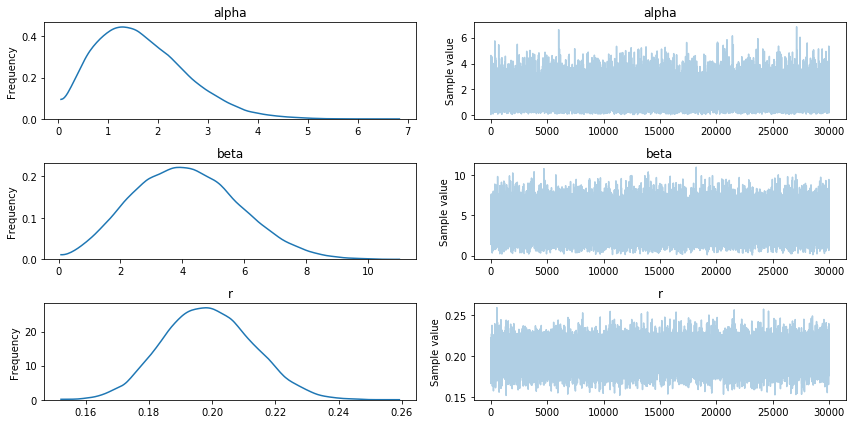

In [54]:
%matplotlib inline

nsamples = 30000
# sampling the model with given data
with model:
    # get sample from model with given observed data
    trace = pymc3.sample(nsamples, chains=1)
    # illustrate samples
    pymc3.traceplot(trace)

### Implementation of Bayesian Logistic Regression 

As part of the extension, I am implementing the Bayesian linear regression model with normal priors for the parameters. Aim is to predict the outcome $Y$ as normally-distributed obeservations with an expected value $\mu$ that is a linear function of two predictor variables $X_{1}$ and $X_{2}$.


<img src="logreg.png"/>
<br>
<center>
$Y$ $\approx$ $N(\mu, \sigma^2)$ <br>
$\mu = \alpha + \beta_{1} X_{1} + \beta_{2} X_{2}$ 
</center>

where $\alpha$ is the intercept, and $\beta_{i}$ is the coefficient for $X_{i}$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior distribution. $\alpha$ and $\beta_{i}$ are normal priors with variance of 100 for both regression coefficients. $\sigma$ prior is a half-normal distribution.

<center>
$\alpha$ $\approx$ $N(0, 100)$<br>
$\beta_{i}$ $\approx$ $N(0, 100)$<br>
$\sigma$ $\approx$ $|N(0,1)|$<br>
</center>

#### Generating Data

I am using numpy to generate artificial data.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5,0,'X2')

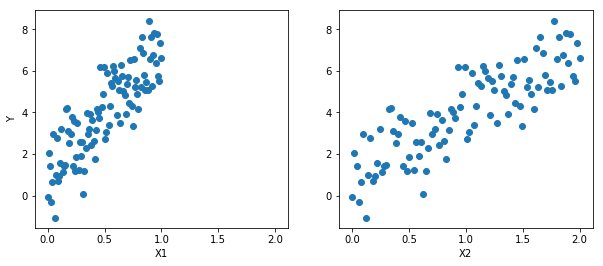

In [32]:
np.random.seed(123)

alpha, sigma = 1, 1
beta = [1, 2.5]

#Size of dataset
size = 100

X1 = np.linspace(0, 1, size)
X2 = np.linspace(0, 2, size)

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

#### Model Specification
Specifiying the model in PyMC3

In [33]:
from pymc3 import Model, Normal, HalfNormal

In [35]:
basic_model = Model()

with basic_model:
    
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    #Likelihood
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)


#### Sampling

A simulation based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution.

In [39]:
from pymc3 import NUTS, sample
from pymc3 import find_MAP
from scipy import optimize

In [40]:
map_estipate = find_MAP(model=basic_model)
with basic_model:
    #Obtain starting values
    start = find_MAP(fmin=optimize.fmin_powell)
    
    #Initialize sampler
    step = NUTS(scaling=start)
    
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

logp = -164.52, ||grad|| = 0.0015524: 100%|██████████| 23/23 [00:00<00:00, 1260.62it/s]  
/usr/local/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -164.95:   8%|▊         | 396/5000 [00:00<00:02, 2159.16it/s]


Optimization terminated successfully.
         Current function value: 164.709367
         Iterations: 9
         Function evaluations: 396


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 2500/2500 [00:23<00:00, 106.19it/s]
The number of effective samples is smaller than 25% for some parameters.


In [41]:
print(trace['alpha'][-5:])

[ 1.03187966  1.0060479   1.27832271  0.62330979  0.69583341]


#### Posterior Analysis

PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using traceplot.

In [42]:
from pymc3 import traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117c794e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118c4a710>]], dtype=object)

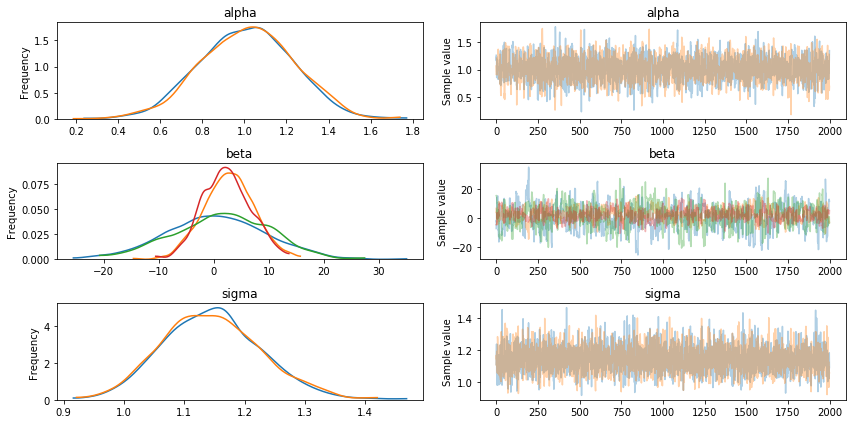

In [43]:
traceplot(trace)

In addition to traceplot the summary function provides a text based output of common posterior statistics.

In [44]:
from pymc3 import summary

In [45]:
summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.011910,0.219669,0.004472,0.607425,1.445726,2399.0,0.999876
beta__0,1.001919,8.855843,0.378973,-15.764043,18.564398,432.0,1.003101
beta__1,2.512560,4.436296,0.189739,-5.752456,11.480272,432.0,1.003185
sigma,1.145926,0.081723,0.001185,1.000814,1.318615,3783.0,0.999763
